In [1]:
# load the libraries required
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import os
from matplotlib import gridspec
from matplotlib.patches import Polygon ## for polygons
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from itertools import islice
import math
from itertools import product
from sklearn import preprocessing
from scipy.stats import gaussian_kde
import requests as rs
import re

from scipy import stats
from scipy.stats import gaussian_kde

%matplotlib inline

# image ploting
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# dictionary of epoc (key) and time range (value) in million years ago
geol_time_dict={'Holocene':(0,0.011700),
               'Pleistocene':(0.011700,2.58),
               'Pliocene':(2.58,5.333),
               'Miocene':(5.333,23.03),
               'Oligocene':(23.0,33.9),
               'Eocene':(33.9,56.0),
               'Paleocene':(56.0,66.0),
               'Late Cretaceous':(66.0,100.5),
               'Early Cretaceous':(100.5,145.0),
               'Jurassic':(145.0,201.3)}
# dictionary of epoc name (key) and list of colour and name abbreviation (value)
geol_col_dict={'Holocene':['#d6d6d6','Hol'], # dark grey
               'Pleistocene':['#ffffff','Ple'], # light grey
               'Pliocene':['#d6d6d6','Pli'],
               'Miocene':['#ffffff','Mio'],
               'Oligocene':['#d6d6d6','Oli'],
               'Eocene':['#ffffff','Eoc'],
               'Paleocene':['#d6d6d6','Pal'],
               'Late Cretaceous':['#ffffff','late Cret'],
              'Early Cretaceous':['#d6d6d6','early Cret'],
              'Jurassic':['#ffffff','Jur']}

# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

----

# 1. Fossil data 

----

## 1.1. Data and fossil age calculations

In [2]:
# def get_data():
#     return pd.read_csv('./pbdb_data_allcc.csv', skiprows=17, delimiter=',')
# try:
#     df = get_data()
# except:
# #     url = "https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&cc=MG&show=full,genus"
#     url = "https://paleobiodb.org/data1.2/occs/list.csv?datainfo&rowcount&show=full,genus"
#     print("Downloading from the Paleobiology database...")
#     res = rs.get(url=url)
# #     with open('./pbdb_data_MG.csv', 'wb') as fp:
#     with open('./pbdb_data_allcc.csv', 'wb') as fp:
#         fp.write(res.content)
#     df = get_data()

# reads the fossil data downloaded by Daniel Edler using the code above
df = pd.read_csv('./Fossils-Madagascar/Genera_records_world.csv', sep=',')
df.columns
# replace no data with zero
df[['early_age', 'late_age']] = df[['early_age', 'late_age']].replace(np.nan,0)
# selects the fossil records from 160 Mya inclusive
df = df[df['early_age'] <= 160].reset_index()
# early age: towards past; late age: towards present
df[['early_age', 'late_age']].describe()

,early_age,late_age
count,13126.000000,13126.000000
mean,41.446046,35.972068
std,45.011763,40.978979
min,0.011700,0.000000
25%,0.781000,0.011700
50%,15.970000,13.600000
75%,83.500000,70.600000
max,145.000000,140.200000


In [3]:
# fossils are dated with a range rather than a single year to accomodate uncertainty on time estimates
# plotting the fossil data either using the early or late ages means that most points will have the same age and visualizing the data as that is uninformative
# to plot fossil data so it is informative, we took the mean age of the fossil and added it to the late_age if the difference between early and late ages is >=1
# if the difference between early and late ages is <1 we simply assigned a random age between the early and late age estimates
# that is to add a sort of "jitter" to the age estimates that is closer to the mean age than to a random number (in case the age range is wide)
def enhance_ma(df):
    df['delta_ma'] = df['early_age'] - df['late_age']
    df['mean_ma'] = df['late_age'] + 0.5*df['delta_ma']
    df['rand_ma'] = df.apply(lambda row: row['mean_ma'] if row['delta_ma'] < 1 else np.random.randint(row['late_age'], row['early_age']), axis=1)

enhance_ma(df)
df[['early_age', 'late_age', 'delta_ma', 'mean_ma', 'rand_ma']]

,early_age,late_age,delta_ma,mean_ma,rand_ma
0,113.0000,100.500,12.5000,106.75000,109.00000
1,132.9000,129.400,3.5000,131.15000,131.00000
2,139.8000,132.900,6.9000,136.35000,137.00000
3,113.0000,100.500,12.5000,106.75000,104.00000
4,59.2000,56.000,3.2000,57.60000,58.00000
...,...,...,...,...,...
13121,0.0117,0.000,0.0117,0.00585,0.00585
13122,15.9700,13.600,2.3700,14.78500,14.00000
13123,13.0000,125.450,-112.4500,69.22500,69.22500
13124,0.7810,0.126,0.6550,0.45350,0.45350


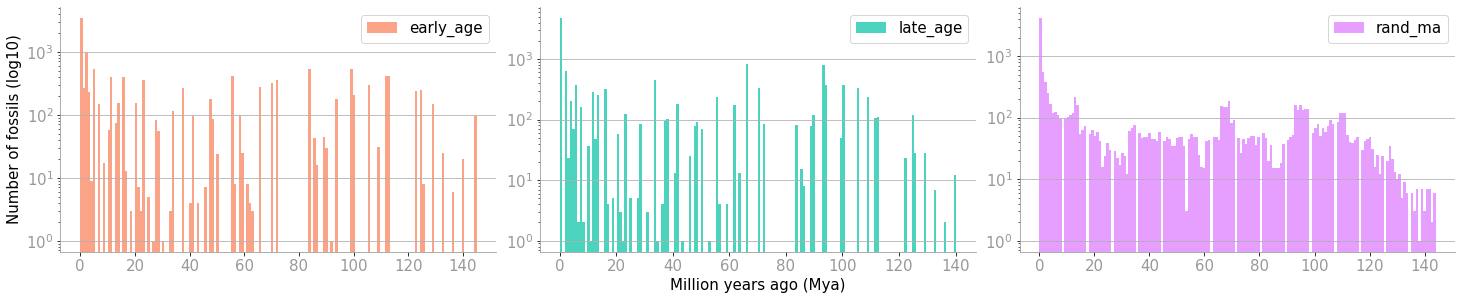

In [4]:
# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,1.5*3),facecolor='w')
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.1)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'
for index,data in enumerate(ages):
    ax=plt.subplot(G[0,index])
    ax.hist(df[ages[index]],bins=160,lw=3,color=colours[index],alpha=0.7,label=ages[index], # 160 bins, 160 Mya
       histtype='stepfilled')
    [ax.spines[loc].set_visible(False) for loc in ['right','top']]
    for spine in ax.spines.values():
        spine.set_edgecolor(spinescol)
    if index == 0:
        plt.ylabel('Number of fossils (log10)',fontsize=15)
    if index == 1:
        plt.xlabel('Million years ago (Mya)',fontsize=15)
    plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
    plt.grid(axis='y')
    plt.yscale('log') # to see the data better
    plt.legend(fontsize=15)
plt.show()

## 1.2. Standardising fossil taxa

In [5]:

print('Example of the information in columns taxon_name, phylum, class, family\n',df[['taxon_name','phylum','class','family']])
print('\n','-'*100,'\n')
print('Unique values in the class column:\n',df['class'].unique())

# adding missing data in the common_name column depending on the value of the phylum column and in whether the class column is empty
for row in df[df['class'].isna()].itertuples():
    if row.phylum == 'Angiospermae':
        df.loc[row.Index,'common_name'] = 'Magnoliopsida'
    if row.phylum == 'Coniferophyta':
        df.loc[row.Index,'common_name'] = 'Other plants'
        
# creates dictionary with the names we need to correct
# we chose these names because they make more sense for a broader public
common_name_dict = {'Mammalia':'Mammals',
                    'Aves':'Birds',
                    'Magnoliopsida':'Flowering plants',
                    'Reptilia':'Reptiles',
                    'Ginkgoopsida':'Other plants',
                    'Saurischia':'Dinosaurs',
                    'Osteichthyes':'Bony fishes'}
# creates new column of common names and maps the chages using the dictionary
df['common_name'] = df['class'].map(common_name_dict)

print('\n','-'*100,'\n')
print('Unique values in the common name column:\n',df['common_name'].unique())

Example of the information in columns taxon_name, phylum, class, family
                     taxon_name    phylum           class             family
0        Otodus appendiculatus  Chordata  Chondrichthyes        Otodontidae
1           Odontaspis studeri  Chordata  Chondrichthyes     Odontaspididae
2           Odontaspis studeri  Chordata  Chondrichthyes     Odontaspididae
3               Corax falcatus  Chordata  Chondrichthyes       Anacoracidae
4            Isurus acuminatus  Chordata  Chondrichthyes           Lamnidae
...                        ...       ...             ...                ...
13121  Coturnix novaezelandiae  Chordata            Aves        Phasianidae
13122    Phalacrocorax auritus  Chordata            Aves  Phalacrocoracidae
13123        Lepidotus cf. sp.  Chordata     Actinopteri                NaN
13124           Ardea herodias  Chordata            Aves           Ardeidae
13125        Casmerodius albus  Chordata            Aves           Ardeidae

[13126 rows x 

In [6]:
# we are only mapping class of land lineages, including bony fishes. Anything else is nan.
cleandf = df[df['common_name'].isin(list(common_name_dict.values()))].copy(deep=True)
print('Number of unique names in common_name column: ',len(cleandf['common_name'].unique()))

# curating taxon_name
cleandf['taxon_corrected'] = cleandf['taxon_name'].str.replace('[^a-zA-Z \d]','') # keeps lower case, upper case, espaces
print('Number of unique names in common_name column after removing non-standard characters: ',len(cleandf['common_name'].unique()))
print('Taxon corrected unique (example):\n',cleandf['taxon_corrected'].unique())

Number of unique names in common_name column:  7
Number of unique names in common_name column after removing non-standard characters:  7
Taxon corrected unique (example):
 ['Mus  sp' 'Sus erymanthius' 'Sus gadarensis' ... 'Puffinus holei'
 'Dendrocygna eversa n sp' 'Anhinga malagurala n sp']


/tmp/ipykernel_174/3944555064.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  cleandf['taxon_corrected'] = cleandf['taxon_name'].str.replace('[^a-zA-Z \d]','') # keeps lower case, upper case, espaces


In [7]:
print('Before and after removing non-standard characers and other signs')
cleandf[['taxon_name','taxon_corrected']]

Before and after removing non-standard characers and other signs


,taxon_name,taxon_corrected
38,Mus ? sp.,Mus sp
39,Sus erymanthius,Sus erymanthius
40,Sus gadarensis,Sus gadarensis
41,Hippopotamus amphibius,Hippopotamus amphibius
50,Sus scrofa,Sus scrofa
...,...,...
13120,Puffinus gavia,Puffinus gavia
13121,Coturnix novaezelandiae,Coturnix novaezelandiae
13122,Phalacrocorax auritus,Phalacrocorax auritus
13124,Ardea herodias,Ardea herodias


### Now, let's see how the plots look like if we only include species found and endemic to Madagascar

## 1.3. Colour dictionaries for common names

In [13]:
# common_names_col = colourDict(cleandf['common_name'].unique(), cmap=mpl.cm.Set2, sort = True)

# using the muted qualitative in https://personal.sron.nl/~pault/
# common_names_col = {'Reptiles': '#88CCEE',
#  'Flowering plants': '#117733',
#  'Bony fishes': '#332288',
#  'Mammals': '#CC6677',
#  'Birds': '#999933',
#  'Dinosaurs': '#999933',
#  'Other plants': '#44AA99'}

# costum
orcoldict = {'Flatworms': '#DDDDDD',
    'Molluscs': '#A3A3A3',
    'Bony fishes': '#2F4858',
    'Arthropods': '#287990',
    'Amphibians': '#26A390',
    'Reptiles': '#BBCC76',
    'Birds': '#ffc4a8',
    'Mammals': '#f58a6f',
    'Flowering plants': '#bd5943',
    'Ferns': '#980f06',
    'Other plants': '#980f06',
    'Dinosaurs': '#620a04'}

In [8]:
# species found in Madagascar (including endemics and species found somewhere else but these are only fossils FROM MG)
df[(df['cc'] == 'MG')]

,index,occurrence_no,record_type,collection_no,taxon_name,taxon_rank,taxon_no,matched_name,matched_rank,matched_no,...,reid_no,regionalsection,regionalbed,regionalorder,subgenus_name,subgenus_reso,delta_ma,mean_ma,rand_ma,common_name
1199,1199,259315,occurrence,25074,Vorona n. gen. berivotrensis n. sp.,species,64129,Vorona berivotrensis,species,64129,...,NaN,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,67.00000,Birds
1410,1410,343957,occurrence,32366,Majungasaurus crenatissimus,species,53957,Majungasaurus crenatissimus,species,53957,...,NaN,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,67.00000,Dinosaurs
1936,1936,405967,occurrence,39074,Rapetosaurus n. gen. krausei n. sp.,species,57533,Rapetosaurus krausei,species,57533,...,NaN,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,69.00000,Dinosaurs
1937,1937,405968,occurrence,25074,Rapetosaurus krausei,species,57533,Rapetosaurus krausei,species,57533,...,NaN,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,66.00000,Dinosaurs
1955,1955,408132,occurrence,32366,Araripesuchus tsangatsangana n. sp.,species,157803,Araripesuchus tsangatsangana,species,157803,...,25277.0,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,66.00000,Reptiles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026,12026,1468983,occurrence,205193,Geckolepis sp.,genus,37904,Geckolepis,genus,37904,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0117,0.00585,0.00585,Reptiles
12311,12311,1506143,occurrence,208970,Adalatherium n. gen. hui n. sp.,species,419515,Adalatherium hui,species,419515,...,NaN,NaN,NaN,NaN,NaN,NaN,6.1000,69.05000,69.00000,Mammals
12773,12773,1527464,occurrence,214154,Akoranemys n. gen. madagasika n. sp.,species,426666,Akoranemys madagasika,species,426666,...,NaN,NaN,NaN,NaN,NaN,NaN,6.6000,97.20000,96.00000,Reptiles
12882,12882,1534912,occurrence,215531,Dromas ardeola,species,402081,Dromas ardeola,species,402081,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0117,0.00585,0.00585,Birds


### All fossils found in MG

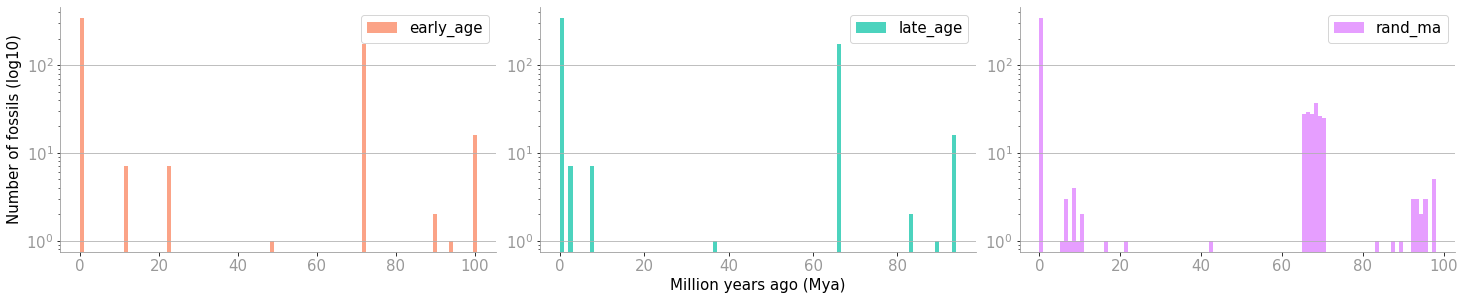

In [9]:
# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,1.5*3),facecolor='w')
G = gridspec.GridSpec(1,3,hspace=0.0,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for index,data in enumerate(ages):
    ax=plt.subplot(G[0,index])
    
    # set the bins
    bins=int(dfMG[ages[index]].max())
    
    # number of bins has to be the max age number in integer to create a bin per 1mya
    ax.hist(dfMG[ages[index]],bins=bins,lw=3,color=colours[index],alpha=0.7,label=ages[index], # 160 bins, 160 Mya
       histtype='stepfilled')
    
    [ax.spines[loc].set_visible(False) for loc in ['right','top']]
    for spine in ax.spines.values():
        spine.set_edgecolor(spinescol)
    if index == 0:
        plt.ylabel('Number of fossils (log10)',fontsize=15)
    if index == 1:
        plt.xlabel('Million years ago (Mya)',fontsize=15)
        
    plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
    plt.grid(axis='y')
    plt.yscale('log') # to see the data better
    plt.legend(fontsize=15)
plt.show()

## 1.4. Pre-visualise the fossil data by common name

### All fossils found in MG by group

In [12]:
dfMG['common_name'].unique()

array(['Birds', 'Dinosaurs', 'Reptiles', 'Mammals', nan, 'Bony fishes',
       'Other plants', 'Flowering plants'], dtype=object)

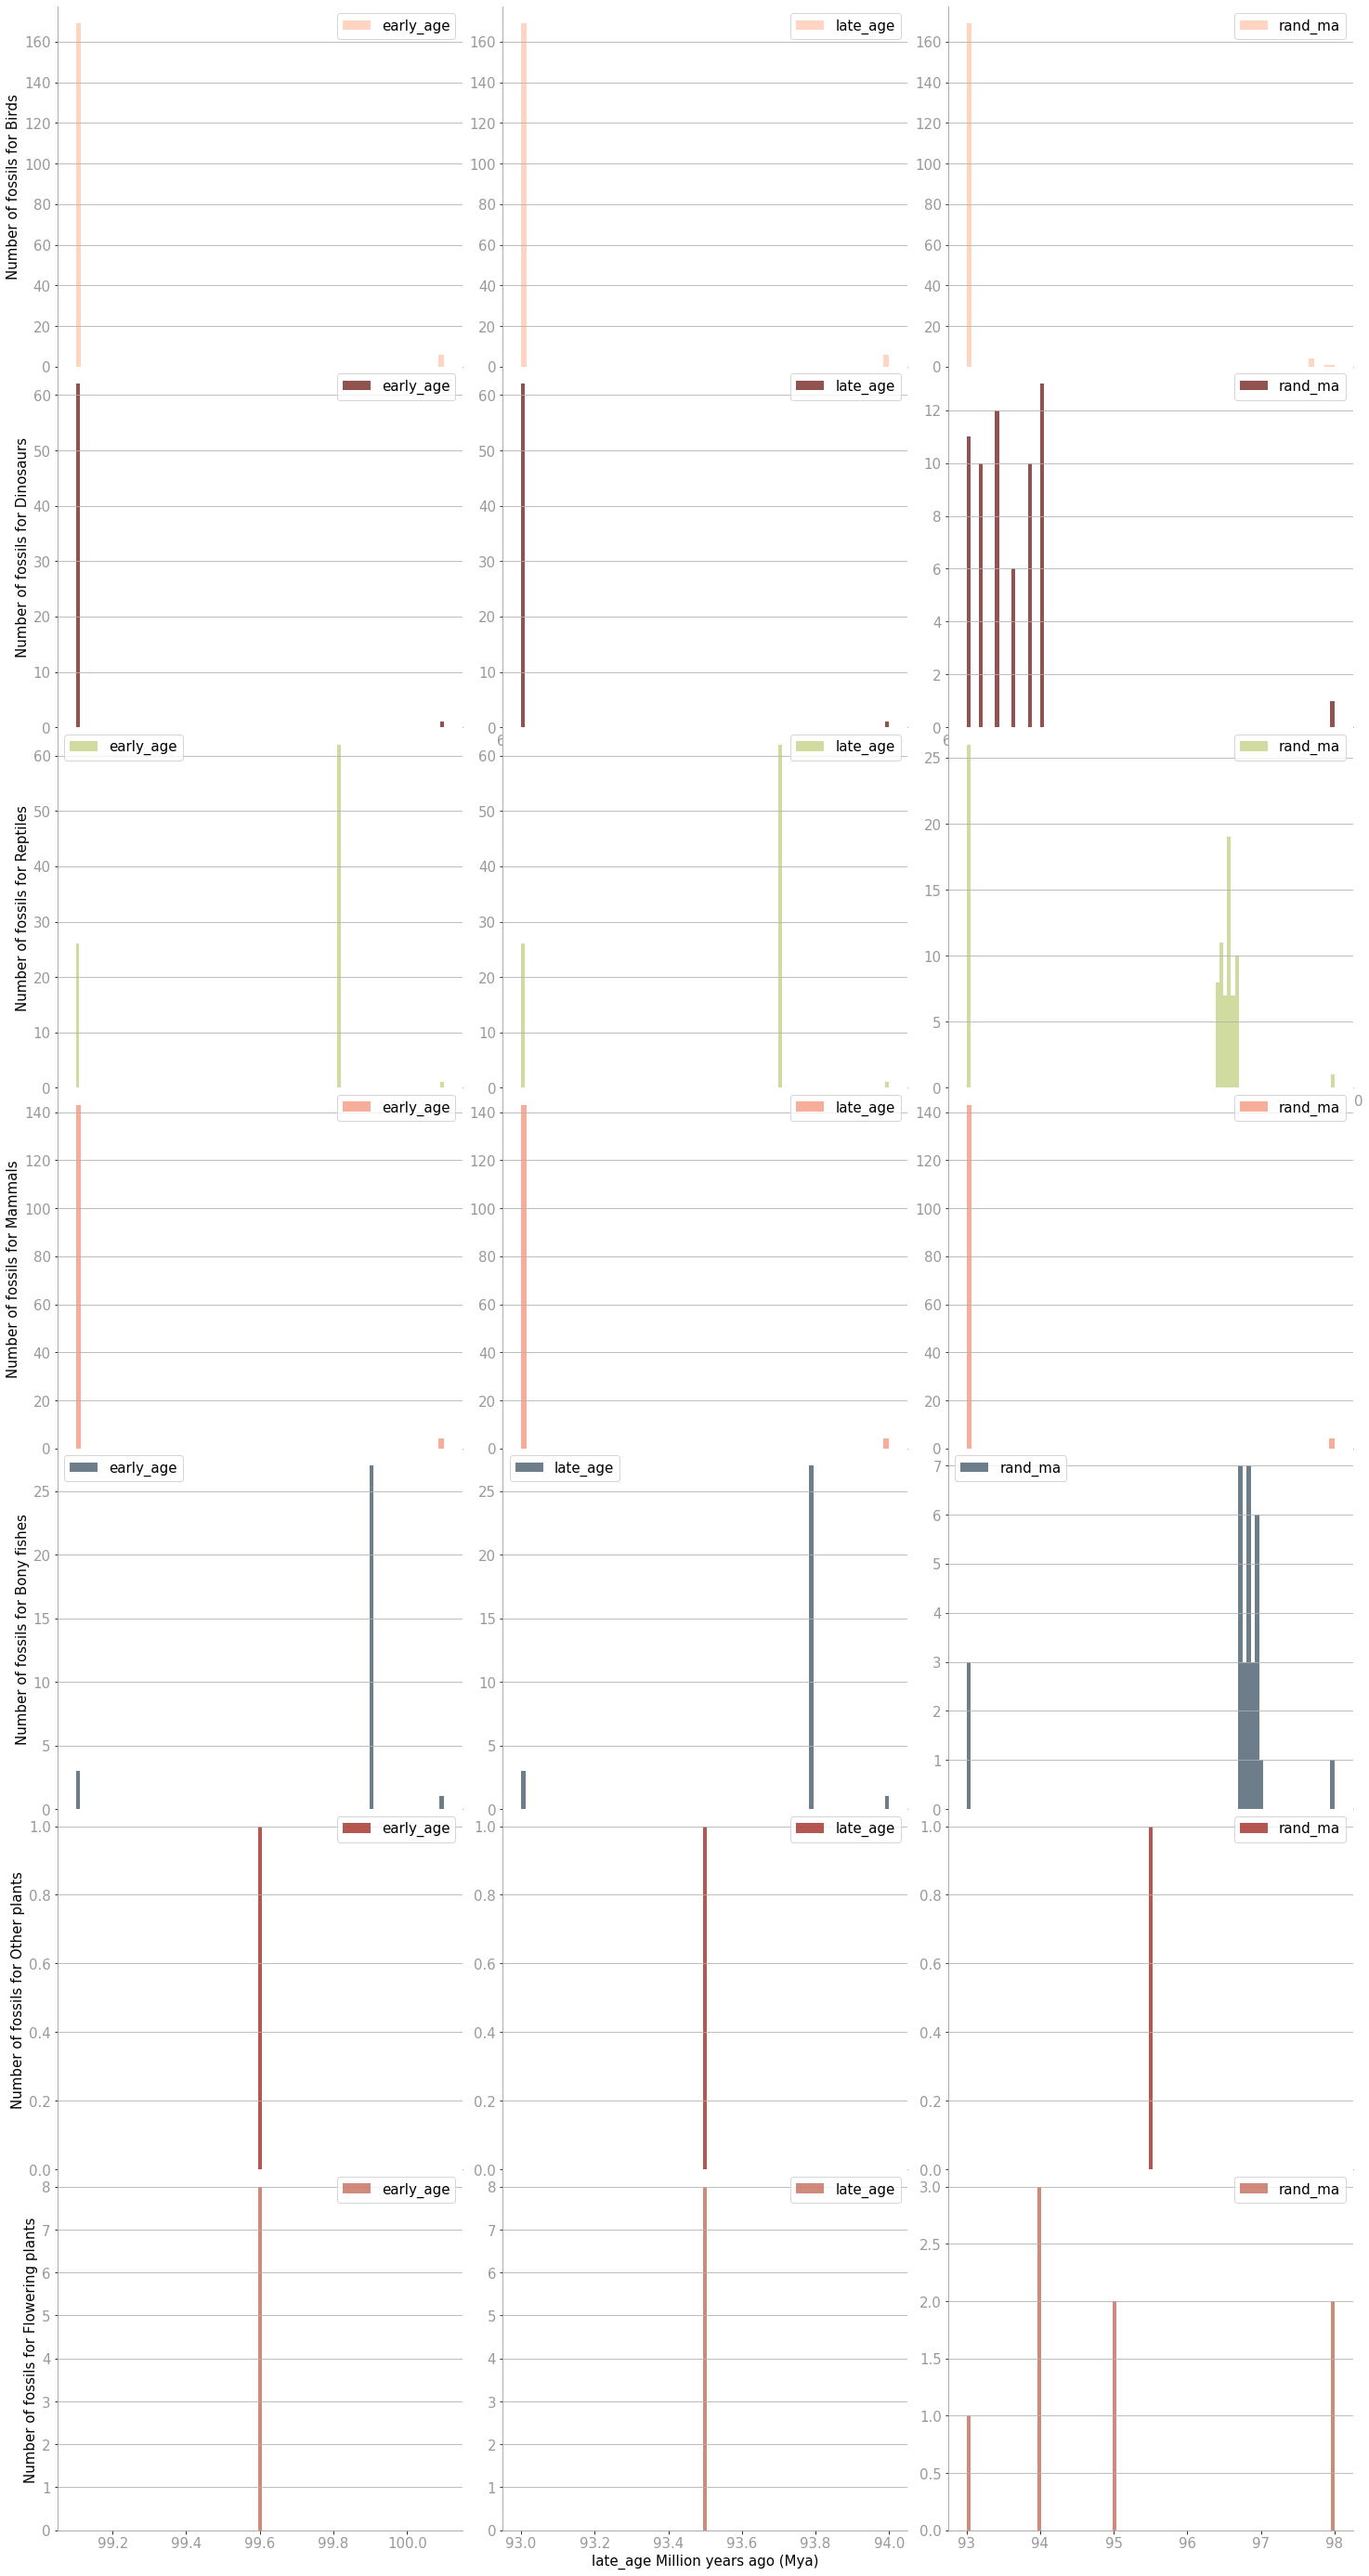

In [14]:
names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,50),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.0,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)
    
    for index,data in enumerate(ages):
        ax=plt.subplot(G[ind,index])
#         try:
            # set the bins
#             print(dfMGtemp[ages[index]].max())
        bins=int(dfMGtemp[ages[index]].astype('float').max())

        # number of bins has to be the max age number in integer to create a bin per 1mya
        ax.hist(dfMGtemp[ages[index]],bins=bins,lw=3,color=orcoldict[name],alpha=0.7,label=ages[index]), # 160 bins, 160 Mya
#                histtype='stepfilled')

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of fossils for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### Unique species of fossils found in MG

In [18]:
dfMG['taxon_name']

1199      Vorona n. gen. berivotrensis n. sp.
1410              Majungasaurus crenatissimus
1936      Rapetosaurus n. gen. krausei n. sp.
1937                     Rapetosaurus krausei
1955      Araripesuchus tsangatsangana n. sp.
                         ...                 
12026                          Geckolepis sp.
12311         Adalatherium n. gen. hui n. sp.
12773    Akoranemys n. gen. madagasika n. sp.
12882                          Dromas ardeola
13075    Falcatakely n. gen. forsterae n. sp.
Name: taxon_name, Length: 548, dtype: object

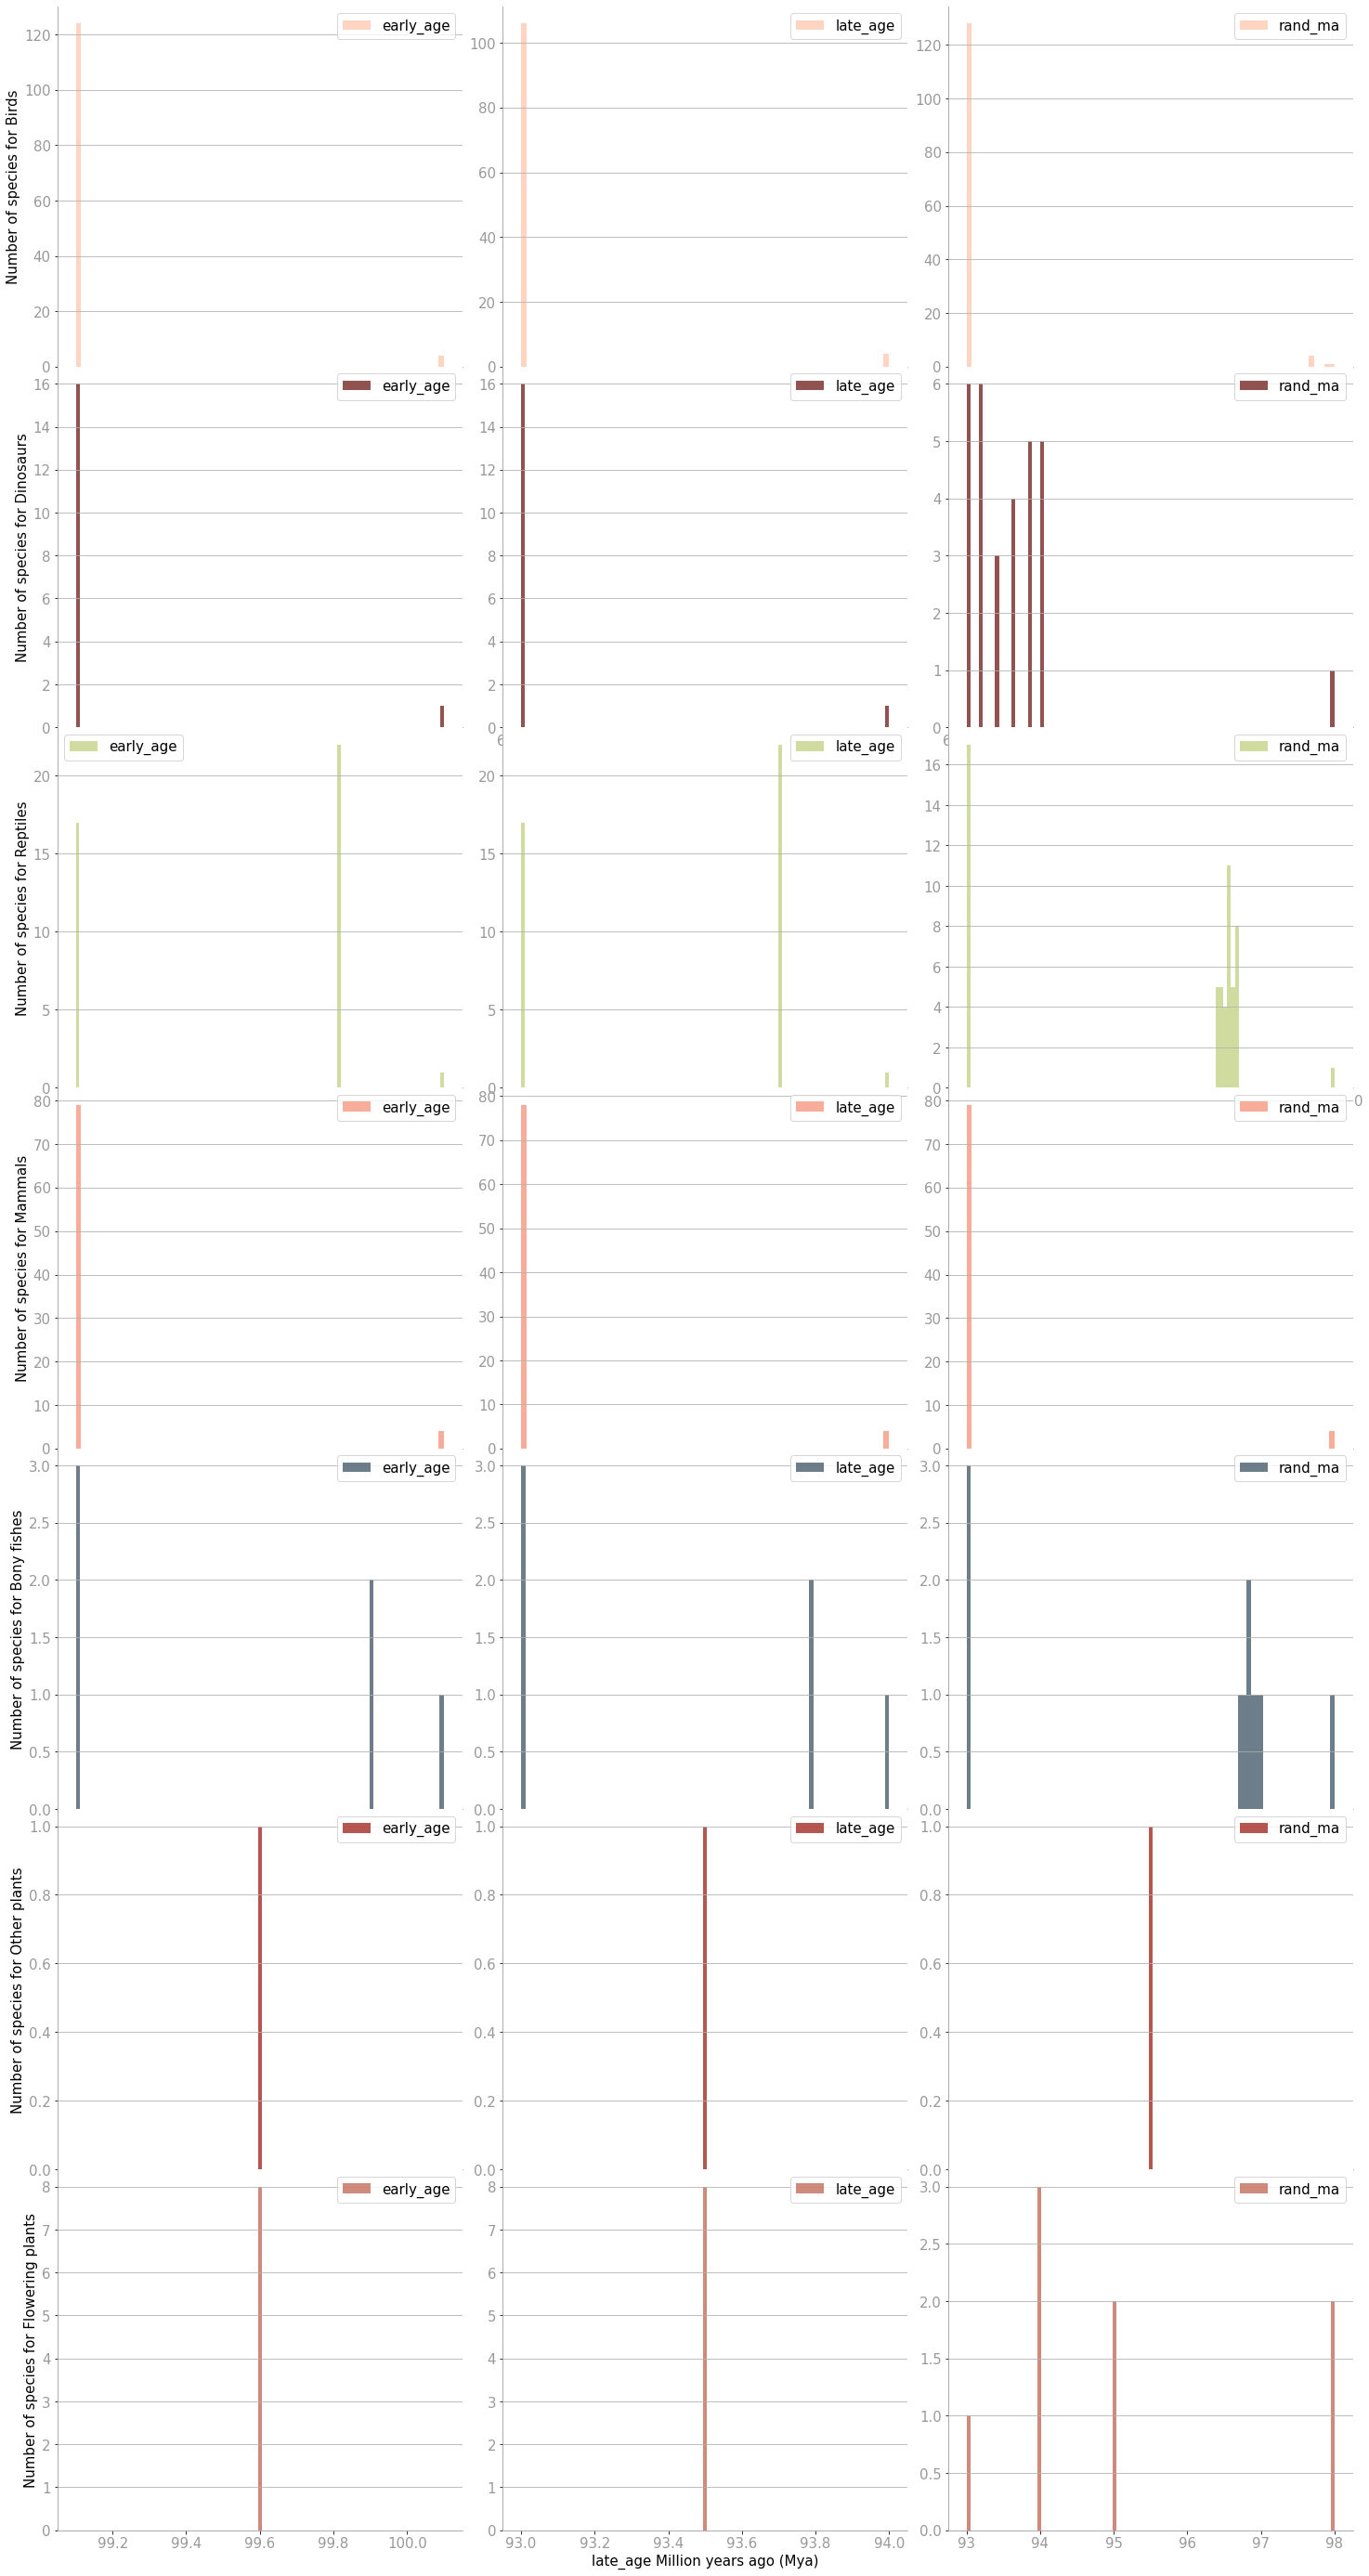

In [24]:
names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,50),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.0,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)

    for index,data in enumerate(ages):
        # group by unique species and time
        byspp=dfMGtemp.groupby(['taxon_name']+[data]).count().reset_index()
        
        ax=plt.subplot(G[ind,index])
        bins=int(byspp[ages[index]].astype('float').max())

        # number of bins has to be the max age number in integer to create a bin per 1mya
        ax.hist(byspp[ages[index]],bins=bins,lw=3,color=orcoldict[name],alpha=0.7,label=ages[index]), # 160 bins, 160 Mya
#                histtype='stepfilled')

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### Unique fossil species from MG through time, size of dots represents number of individual fossils

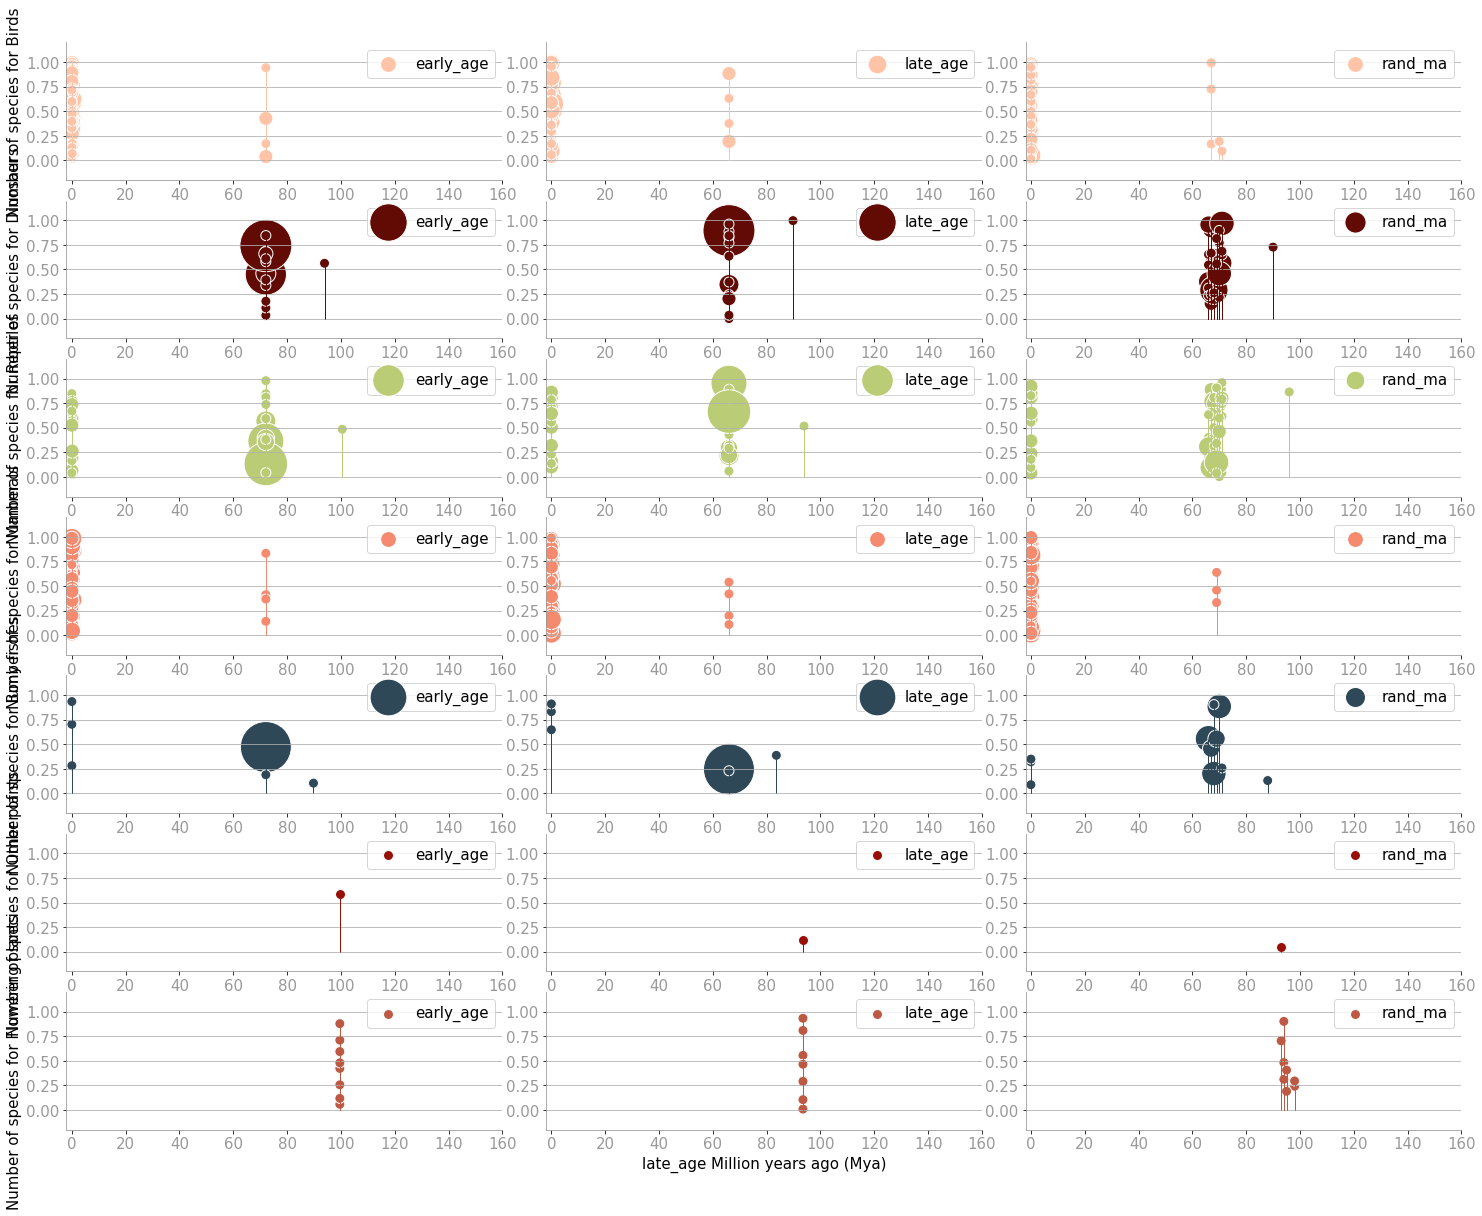

In [45]:
import random

names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,20),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.15,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)

    for index,data in enumerate(ages):
        # group by unique species and time
        byspp=dfMGtemp.groupby(['taxon_name']+[data]).count().reset_index()
#         print(byspp[['taxon_name','early_age','late_age','rand_ma','occurrence_no']].isna().describe())
        
        ax=plt.subplot(G[ind,index])
        ax.set_xlim(-2,160); ax.set_ylim(-0.2,1.2)
        
        yrandomlist=[]
        for line in byspp[data].values:
            yrandom=random.uniform(0, 1)
            yrandomlist.append(yrandom)
            ax.vlines(x=line, ymin=0, ymax=yrandom,color=orcoldict[name], lw=1)
            
        ax.scatter(x=byspp[data], y=yrandomlist, facecolor=orcoldict[name], edgecolor='w',
                   marker='o', s=byspp['occurrence_no']*100, alpha=1, label=data)

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### Unique fossil species from MG through time, size of dots represents number of unique species

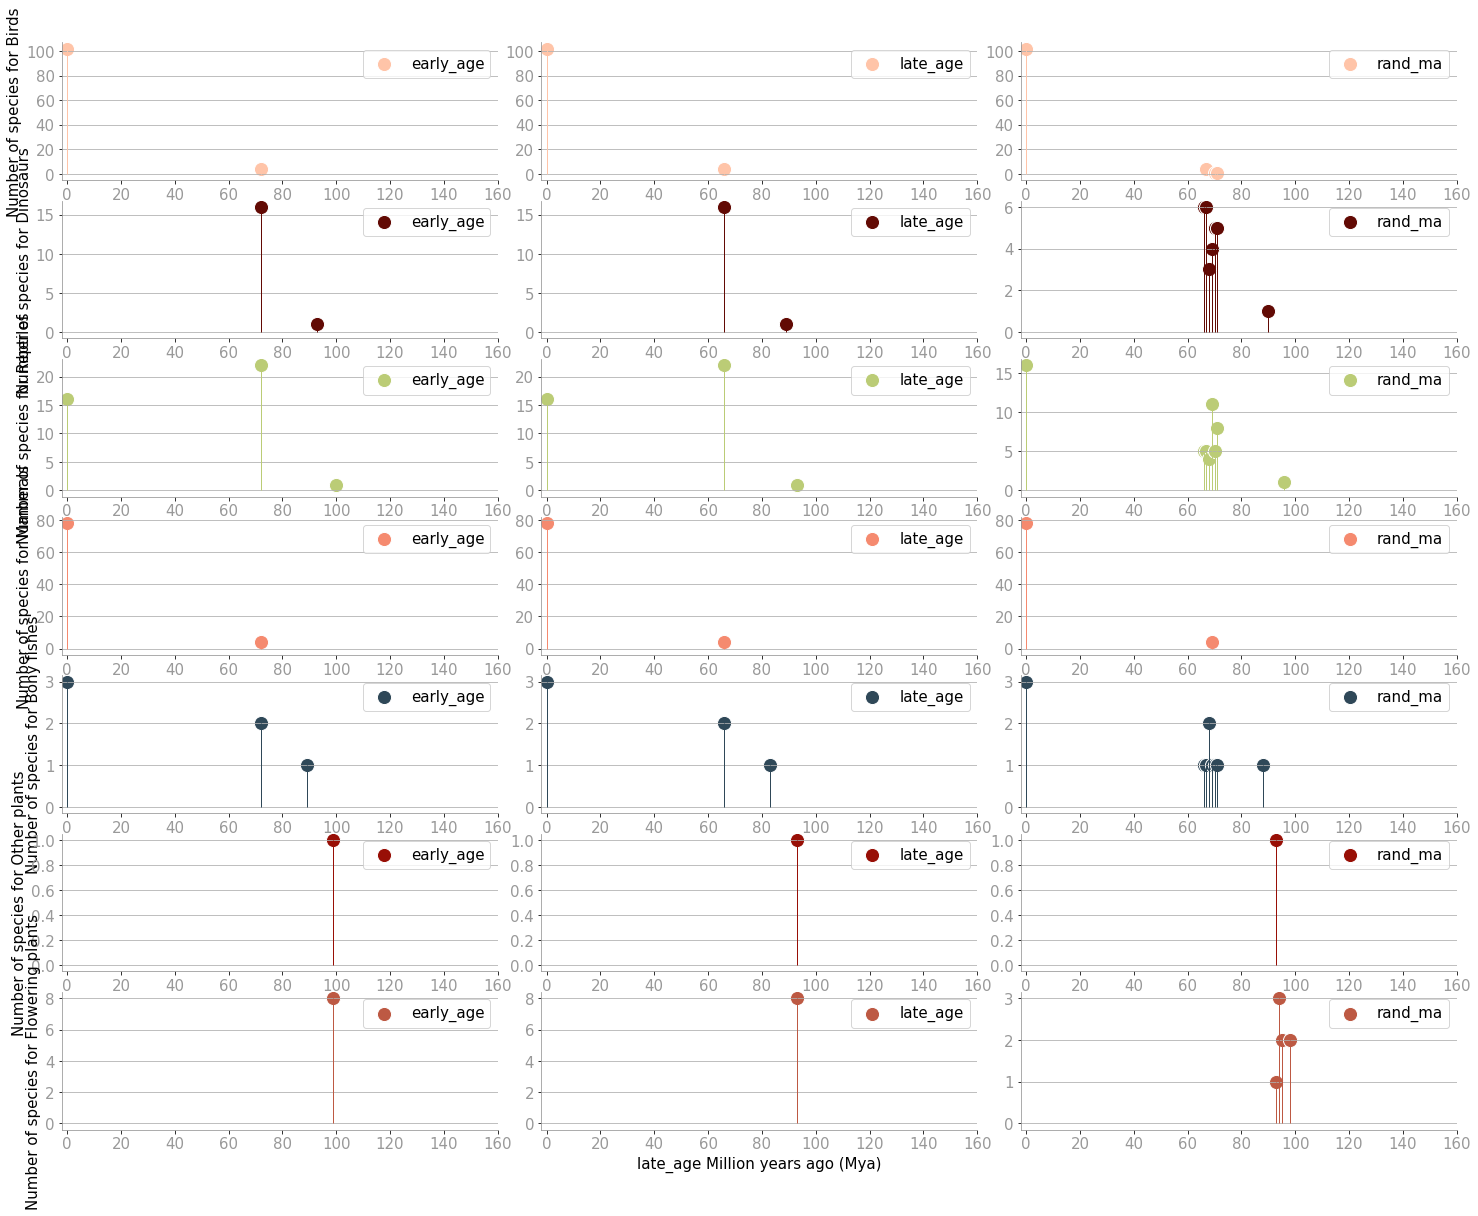

In [67]:
import random

names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,20),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.15,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)
    
    for index,data in enumerate(ages):
        # make time integer so that I can group by year and count the number of unique species
        dfMGtemp.loc[dfMGtemp.index,data]=dfMGtemp.loc[dfMGtemp.index,data].astype('int')
    
        # group by unique species and time
        byspp=dfMGtemp.groupby(data).nunique()['taxon_name'].reset_index()
#         print(byspp.head())
        
        ax=plt.subplot(G[ind,index])
        ax.set_xlim(-2,160); #ax.set_ylim(0,1.2)
            
        ax.scatter(x=byspp[data], y=byspp['taxon_name'], facecolor=orcoldict[name], edgecolor='w',
                   marker='o', s=200, alpha=1, label=data)
        ax.vlines(x=byspp[data], ymin=0, ymax=byspp['taxon_name'],color=orcoldict[name], lw=1)

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

### with endemics highlighted

In [70]:
# list of fossils found only in one country
taxon_countries = df.groupby('taxon_name').nunique()['cc'].reset_index()
    # make a list of the taxons found only in one country
singlecountry = list(taxon_countries[taxon_countries['cc'] == 1]['taxon_name'])

# filter the data so that only taxon found in a single country and in Madagascar are left
endemic = df[ (df['taxon_name'].isin(singlecountry)) & (df['cc'] =='MG') ]
endemic[['taxon_name','cc']]

,taxon_name,cc
1199,Vorona n. gen. berivotrensis n. sp.,MG
1410,Majungasaurus crenatissimus,MG
1936,Rapetosaurus n. gen. krausei n. sp.,MG
1937,Rapetosaurus krausei,MG
1955,Araripesuchus tsangatsangana n. sp.,MG
...,...,...
12026,Geckolepis sp.,MG
12311,Adalatherium n. gen. hui n. sp.,MG
12773,Akoranemys n. gen. madagasika n. sp.,MG
12882,Dromas ardeola,MG


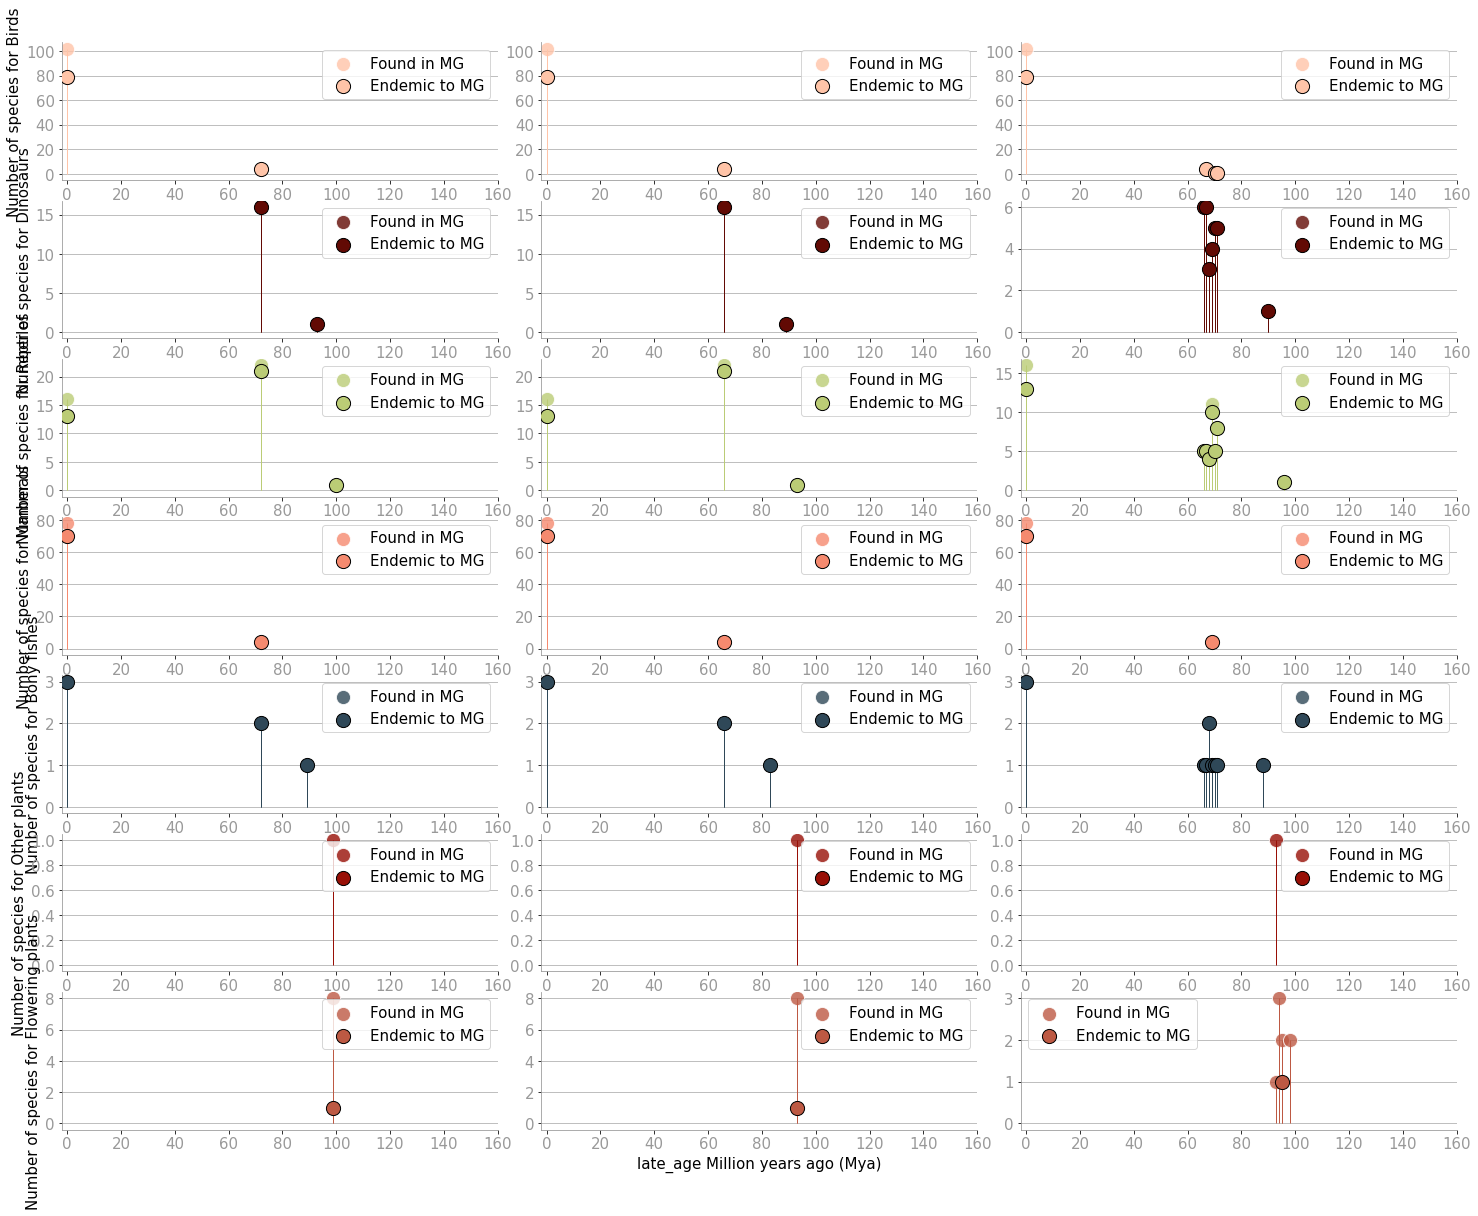

In [72]:
names=dfMG['common_name'].dropna().unique()

# let's quickly plot the fossil data and compare between the raw and enhanced ages
plt.figure(figsize=(25,20),facecolor='w')
G = gridspec.GridSpec(len(names),3,hspace=0.15,wspace=0.1)

dfMG=df[(df['cc'] == 'MG')].copy(deep=True)

# https://mycolor.space/?hex=%23FA7C54&sub=1 colour pallete
colours=['#fa7c54','#00c1a3','#dc75ff']
ages=['early_age','late_age','rand_ma']
spinescol='#999999'

for ind,name in enumerate(names):
    # filter by common name (see cell above)
    dfMGtemp=dfMG[dfMG['common_name']==name].copy(deep=True)
    endemictemp=endemic[endemic['common_name']==name].copy(deep=True)
    
    for index,data in enumerate(ages):
        # make time integer so that I can group by year and count the number of unique species
        dfMGtemp.loc[dfMGtemp.index,data]=dfMGtemp.loc[dfMGtemp.index,data].astype('int')
        endemictemp.loc[endemictemp.index,data]=dfMGtemp.loc[endemictemp.index,data].astype('int')
        
        # group by unique species and time
        byspp=dfMGtemp.groupby(data).nunique()['taxon_name'].reset_index()
        bysppend=endemictemp.groupby(data).nunique()['taxon_name'].reset_index()
#         print(byspp.head())
        
        ax=plt.subplot(G[ind,index])
        ax.set_xlim(-2,160); #ax.set_ylim(0,1.2)
            
        ax.scatter(x=byspp[data], y=byspp['taxon_name'], facecolor=orcoldict[name], edgecolor='w',
                   marker='o', s=200, alpha=0.8, zorder=2, label='Found in MG')
        ax.vlines(x=byspp[data], ymin=0, ymax=byspp['taxon_name'],color=orcoldict[name], lw=1)
        
        ax.scatter(x=bysppend[data], y=bysppend['taxon_name'], facecolor=orcoldict[name], edgecolor='k',
                   marker='o', s=200, alpha=1, zorder=3, label='Endemic to MG')
        ax.vlines(x=bysppend[data], ymin=0, ymax=bysppend['taxon_name'],color=orcoldict[name], lw=1)

        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        for spine in ax.spines.values():
            spine.set_edgecolor(spinescol)
        if index == 0:
            plt.ylabel('Number of species for %s'%(name),fontsize=15)
        if index == 1:
            plt.xlabel('%s Million years ago (Mya)'%(ages[index]),fontsize=15)

        plt.yticks(fontsize = 15, color=spinescol); plt.xticks(fontsize = 15, color=spinescol)
        plt.grid(axis='y')
        plt.legend(fontsize=15)

plt.show()

----

# 2. Extant data

----

## 2.1. Loading the data

In [73]:
# load data (available in supplementary material)
extant=pd.read_csv('./Extant_data/lineage_data_clean_v3.csv',sep='\t')
print('Unique group names in extant data:\n')
print(extant['Group'].unique())
extant_order = ['Flatworms','Molluscs','Bony fishes','Arthropods','Amphibians','Reptiles','Birds','Mammals','Flowering plants','Ferns']
print('Extanct taxa will be used in the following order:\n',extant_order)
fossil_order = ['Other plants','Flowering plants','Mammals','Dinosaurs','Reptiles','Birds','Bony fishes']
print('Fossils will be used in the following order:\n',fossil_order)

print('\n','-'*100,'\n')

# # sorting the data
extant.sort_values(by='crown_age_plot', ascending = True, inplace = True); extant.reset_index(inplace=True)
extant[['crown_age_plot','stem_age_plot']]=extant[['crown_age_plot','stem_age_plot']].astype('float')
# summary of crown and stem ages across all species and to make sure data is float
print('Summary of crown and stem ages across all extant records')
extant[['crown_age_plot','stem_age_plot']].describe()

Unique group names in extant data:

['Amphibians' 'Arthropods' 'Birds' 'Bony fishes' 'Ferns' 'Flatworms'
 'Flowering plants' 'Mammals' 'Reptiles' 'Molluscs']
Extanct taxa will be used in the following order:
 ['Flatworms', 'Molluscs', 'Bony fishes', 'Arthropods', 'Amphibians', 'Reptiles', 'Birds', 'Mammals', 'Flowering plants', 'Ferns']
Fossils will be used in the following order:
 ['Other plants', 'Flowering plants', 'Mammals', 'Dinosaurs', 'Reptiles', 'Birds', 'Bony fishes']

 ---------------------------------------------------------------------------------------------------- 

Summary of crown and stem ages across all extant records


,crown_age_plot,stem_age_plot
count,206.000000,213.000000
mean,17.392233,29.247371
std,19.915088,28.400954
min,0.100000,1.000000
25%,4.000000,8.500000
50%,10.000000,19.500000
75%,23.202500,40.400000
max,151.000000,177.000000


----

# 3. Event data

----

## 3.1. Loading the data

In [ ]:
# geological/environmental events 
eventspre=pd.read_csv('./Extant_data/mada_paleo_events_20220911.tsv',sep='\t') # 'time_Ma_from','time_Ma_to','short','location','type',
events = eventspre[eventspre['plot'] == 'y'] # filter the events selected to be in Fig1
print('Unique type events to plot:\n', events['type'].unique(),'\n')
print('\n','-'*100,'\n')

bars = events[events['do_as'] == 'bar'].copy(deep=True)
bars.sort_values(by = 'time_Ma_to', ascending= True, inplace = True)
print('Event types to plot as bars:\n',list(bars['type'].unique()),'\n')
# # events[['time_Ma_from','time_Ma_to','short','location','type']]

# dictionaries with more events, I guess I got bored of doing mini-dataframes
dispersal = list(zip(bars[bars['type'] == 'dispersal']['time_Ma_to'], bars[bars['type'] == 'dispersal']['time_Ma_from_plot']))
landbridges = list(zip(bars[bars['type'] == 'landbridges']['time_Ma_to'], bars[bars['type'] == 'landbridges']['time_Ma_from_plot']))
submerged = list(zip(bars[bars['type'] == 'submerged']['time_Ma_to'], bars[bars['type'] == 'submerged']['time_Ma_from_plot']))
uplift = list(zip(bars[bars['type'] == 'uplift']['time_Ma_to'], bars[bars['type'] == 'uplift']['time_Ma_from_plot']))
volcanism = list(zip(bars[bars['type'] == 'volcanism']['time_Ma_to'], bars[bars['type'] == 'volcanism']['time_Ma_from_plot']))
biota = list(zip(bars[bars['type'] == 'biota']['time_Ma_to'], bars[bars['type'] == 'biota']['time_Ma_from_plot'])) # added 2022/09/11
climate = list(zip(bars[bars['type'] == 'climate']['time_Ma_to'], bars[bars['type'] == 'climate']['time_Ma_from_plot'])) # added 2022/09/11
landscape = list(zip(bars[bars['type'] == 'landscape']['time_Ma_to'], bars[bars['type'] == 'landscape']['time_Ma_from_plot'])) # added 2022/09/11

# more events added as we went
lineevents = {'Oligocene shift to cooling':34, 'K-Pg boundary extinction':66}

# shade events in the background. Hardcoded after sveral rounds of datababse updates and table versions
# Same colour but each has its oun colour item just in case
shadeevents = {'Monsoons start to hit north':[5.332999999999999, 11.63,'#fcd144'],
              'Arid conditions across the island':[27.82, 65.0,'#fcd144'],
              'Separation from Seychelles block':[84.0, 91.0,'#fcd144'],
#               'Western basins marine':[23.0,140.0,'#fcd144'],
               u'Southernmost position at 52\u00B0':[112,124.5,'#fcd144'], # added 2022/09/11
              'Separation from Africa':[150.0, 160.0,'#faeb87']}

In [ ]:
# lineage origin color dictionary
origins = ['Africa', 'Eurasia', 'Indopacific', 'Neotropics', 'North America']
orcoldictunique = colourDict(origins, cmap=mpl.cm.Dark2, sort = False)

# orcoldict['Unknown'] = '#ffffff'
orcoldictunique['Unknown'] = '#ffffff'
edgecolordict = dict(zip(origins,['w' if loc != 'Unknown' else '#bababa' for loc in origins]))

In [ ]:
# counting total lineages for each common_names and adding them across datasets
# these counts will be used as "bottoms" and "left edges" for plotting
# basically, to know how wide the pannel for each common name group should be to acomodate all lineages for which we have stem and crown data
extant_span = {}
for name in extant['Group'].unique():
    count = len(extant[extant['Group'] == name])
    # take the largest number to set the xaxis span (ple will be plot on top of holo and we want the groups to correspond)
    extant_span[name] = count
extant_span

----

# 4. Plotting functions

----  


In [ ]:
def addvolcanos(data, ax = '', holocene = False, offset = 0.5, color = '#a30000', levels = 3):
    """
    adds shades to denote long events
    data is a list of tuples, with data[0] == earliest (to the past) and data[1] == most recent dates
    """
    y = 0
    track = 0
    ylist = []
    while track <= len(volcanism):
        for i in range(levels):
            ylist.append(i); track += 1
    for index,pair in enumerate(data):
        if holocene == False:
            if pair[1] > 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                xmin = pair[0]
                xmax = pair[1]
        elif holocene == True:
            if pair[1] <= 2.58: # if earliest date is more recent than 2.58, the most-present date will be
                xmin = pair[0]
                xmax = pair[1]
        else:
            xmin = pair[0]
            xmax = pair[1]
        ax.barh(y = ylist[index] + offset, width = xmax - xmin, height = offset, 
                left = xmin, align = 'center', edgecolor = 'w', lw = 2, alpha = 1, color = 'w', zorder = 10)
        ax.barh(y = ylist[index] + offset, width = xmax - xmin, height = offset, 
                left = xmin, align = 'center', edgecolor = 'none', lw = 0, alpha = 1, color = color, zorder = 11)       
    return ax

def lineageplot(dataset,ax,colby='sister_lineage_plot',colbydict=orcoldict,by='common_name',byorder='',unit='name', 
                crown='mean_crown_plot',stem='mean_stem_plot',
                width=1,bottom=0,ybase=0,offset=2,span='',
                tickrange=20,lw=1, zorder = 100, edgecolor = 'none'):
    """
    plots lineage ages from left (earliest crown age) to right (crown ages closest to present)
    dataset=dataframe object
    colby=column name (str) by which the colour is applied
    colbydict=dictionary for colby with values == colors
    by=column name (str) by which separate the lineage groups
    byorder=ordered list of names if random order is not desired
    unit=column name (str) that represent lineage units (plotted as a vertical bar)
    crown=column name (str) with the crown ages
    stem=column name (str) with the stem ages
    span=dictionary name:distance with the span on the x axis between each 'by' group
    """
    plt.gca().invert_xaxis()
    names=[]
    if byorder!= '':
        names=byorder
    else:
        names=dataset[by].unique()
    for phy in names:
        temp = dataset[dataset[by] == phy].drop_duplicates(subset=[by,unit])  # the original list has duplicated entries when two papers had different 95% age ranges. We are using the 
        y = [i + ybase for i,x in enumerate(temp[unit].unique())]
        height = temp[crown].values
        ax.barh(y = y, height = width, width = height, left = bottom, align = 'center',
               edgecolor = edgecolor, lw = lw, alpha = 1, # [edgecolordict[x] for x in temp[colby]]
               color = [colbydict[x] for x in temp[colby]], zorder = zorder)
        # plotting stem ages when available
        ax.hlines(y = [(i + ybase) for i,y in enumerate(temp[unit].unique())],
                  xmin = temp[crown], xmax = temp[stem], color = [colbydict[x] for x in temp[colby]], lw = 0.5, zorder = 5)
        # adds an extra space to separate lineages from each 'common name'
        ybase +=  offset + (span[phy]  if span != '' else len(temp[stem].values)) # len(temp[crown].values) # (len(temp[crown].values) + len(temp[stem].values))/2

    # set xlims using the last ybase value set
    ax.set_ylim(-5,ybase)
    ax.set_yticks([])

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    return ax

----

# 5. Plotting fossil (lines) and extant (bars) data through time from 160 Mya to present

----  

In [ ]:
len(fossil_order)

In [ ]:
fig1=plt.figure(figsize=(18,29.7),facecolor='None')
ratio_events = 0.025
G = gridspec.GridSpec(13,1,hspace=0.01,wspace=0.0,
                      height_ratios=[2,0.03,0.6,ratio_events,ratio_events,ratio_events,ratio_events,ratio_events,
                                     ratio_events,ratio_events,0.01,0.03,0.08])
text_color='k'#'#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
fontstyle='normal'
xlimmax=160
# ------------------------------------------------------------------------- extant
whitedict = {key:'#ffffff' for key in orcoldict.keys()}
# greydict = {key:'#787878' for key in orcoldict.keys()}
ax7=plt.subplot(G[0,0])
ax7.set_xlim(xlimmax,0);plt.gca().invert_xaxis() # extant_order # sorted(extant_span.keys())
lineageplot(extant, ax = ax7, colby = 'Group', colbydict = whitedict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'crown_age_plot',
            width = 1.05, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 2.5, edgecolor = 'w');
plt.gca().invert_xaxis() # extant_span
lineageplot(extant, ax = ax7, colby = 'Group', colbydict = orcoldict, by = 'Group', byorder = extant_order, unit = 'Lineage',
            crown = 'crown_age_plot', stem = 'stem_age_plot',
            width = 1.06, bottom = 0, ybase = 0, offset = 3,span = '', tickrange = 50, lw = 0.3, edgecolor = 'none') # extant_span
# print(extant_order)

# ------------------------------------------------------------------------- space
axsp1=plt.subplot(G[1,0])
axsp1.set_xlim(xlimmax,0)

# ------------------------------------------------------------------------- fossil
unit = 'taxon_name'
width = 1
cleandf['timebin'] = pd.cut(cleandf['rand_ma'],labels = False, bins = round(cleandf['rand_ma'].max()))
endemicdb = cleandf[cleandf['cc']=='MG']

axfoss=gridspec.GridSpecFromSubplotSpec(len(fossil_order),1, subplot_spec=G[2,0], hspace=0.02) # plt.subplot(G[2,0])
for index,axf in enumerate(axfoss):
    axf1 = fig1.add_subplot(axf)
    axf1.set_xlim(xlimmax,0)
    temp = cleandf[cleandf['common_name'] == fossil_order[index]].groupby(by='timebin')[unit].count().reset_index()
    endtemp = endemicdb[endemicdb['common_name'] == fossil_order[index]].groupby(by='timebin')[unit].count().reset_index()
    
    axf1.plot(temp['timebin'],np.log(temp[unit]), color = 'w', zorder = 8, lw = 6, alpha = 1)
    axf1.plot(temp['timebin'],np.log(temp[unit]), color = orcoldict[fossil_order[index]], zorder = 9, lw = 4)

    for timebin in endtemp['timebin'].unique():
        endtemp1 = endtemp[endtemp['timebin'] == timebin]
        bottom = 0
        heightend = np.log(endtemp1[unit])
        axf1.bar(x = timebin, width = width, height = heightend, bottom = bottom, align = 'edge', 
                facecolor = orcoldict[fossil_order[index]], edgecolor = 'w',zorder = 11, lw = 1, alpha = 1)
    plt.grid(axis='y')
    axf1.set_xticks([]); 
#    axf1.set_yticks(ticks=[y for y in axf1.get_xticklabels()],labels=[np.log(y) for y in axf1.get_xticklabels()]); #get_xticklabels
    [axf1.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
    for key,value in shadeevents.items():
        axf1.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
    for key,value in lineevents.items():
        axf1.vlines(x = value, ymin = axf1.get_ylim()[0], ymax = axf1.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
    axf1.vlines(x = [mya for mya in range(0,170,10)],
                ymin = axf1.get_ylim()[0], ymax = axf1.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)

    axf1.set_ylim(-0.2,ymax = axf1.get_ylim()[1])

#  ['biota', 'volcanism', 'uplift', 'climate', 'landbridges', 'dispersal', 'submerged'] 
#  ['biota', ''climate']
# ------------------------------------------------------------------------- climate
axclim=plt.subplot(G[3,0])
axclim.set_xlim(xlimmax,0)
addvolcanos(climate, holocene = '', offset = 0.015, color = eventbarcolor, ax = axclim, levels = 1)
axclim.text(y=(axclim.get_ylim()[1]/2),x=axclim.get_xlim()[0]-1,s='Climate variation',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- uplift
ax5=plt.subplot(G[4,0])
ax5.set_xlim(xlimmax,0)
addvolcanos(uplift, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax5, levels = 1)
ax5.text(y=(ax5.get_ylim()[1]/2),x=ax5.get_xlim()[0]-1,s='Neogene convective uplift',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- submerged
ax4=plt.subplot(G[5,0])
ax4.set_xlim(xlimmax,0)
addvolcanos(submerged, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax4, levels = 1)
ax4.text(y=(ax4.get_ylim()[1]/2),x=ax4.get_xlim()[0]-1,s='Marine conditions in W Madagascar',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- landbridges
ax3=plt.subplot(G[6,0])
ax3.set_xlim(xlimmax,0)
addvolcanos(landbridges, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax3, levels = 1)
ax3.text(y=(ax3.get_ylim()[1]/2),x=ax3.get_xlim()[0]-1,s='Land bridges',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- volcanism
ax6=plt.subplot(G[7,0])
ax6.set_xlim(xlimmax,0)
addvolcanos(volcanism, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax6, levels = 1)
ax6.text(y=(ax6.get_ylim()[1]/2),x=ax6.get_xlim()[0]-1,s='Volcanism',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- dispersal
ax2=plt.subplot(G[8,0])
ax2.set_xlim(xlimmax,0)
addvolcanos(dispersal, holocene = '', offset = 0.015, color = eventbarcolor, ax = ax2, levels = 1)
ax2.text(y=(ax2.get_ylim()[1]/2),x=ax2.get_xlim()[0]-1,s='Favourable current from Africa',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- biota
axbiota=plt.subplot(G[9,0])
axbiota.set_xlim(xlimmax,0)
addvolcanos(biota, holocene = '', offset = 0.015, color = eventbarcolor, ax = axbiota, levels = 1)
axbiota.text(y=(axbiota.get_ylim()[1]/2),x=axbiota.get_xlim()[0]-1,s='Biota',color=text_color,
         fontstyle=fontstyle,rotation=0,fontsize=textsize,fontname=fontname,va='bottom',ha='left')

# ------------------------------------------------------------------------- space
axsp2=plt.subplot(G[10,0])
axsp2.set_xlim(xlimmax,0)
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[11,0])
ax1.set_xlim(xlimmax,0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.barh(y = 0, width = value[1] - value[0], height = 2, left = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 0.5, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
ax1.set_xticks([])
ax1.tick_params(axis='x', colors='w')
[ax1.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
plt.xticks(fontsize = 12, color='k'); # prints labels only in the first subplot
# ------------------------------------------------------------------------- space
axsp3=plt.subplot(G[12,0])
axsp3.set_xlim(xlimmax,0)
axsp3.set_ylim(0,1)
for index,(key,value) in enumerate(shadeevents.items()):
    axsp3.hlines(y = 0.9, xmin = value[0], xmax = value[1], lw = 2, color = eventbarcolor, zorder=10)
# ------------------------------------------------------------------------- events yaxis settings
for axx in ax7,ax6,ax5,ax3,ax2,ax4,ax1,axclim,axbiota,axsp1,axsp2,axsp3:#,axfoss:
    if axx != ax1:
        axx.set_yticks([]);axx.set_xticks([])
        [axx.spines[loc].set_visible(False) for loc in ['top','right','bottom','left']]
        for key,value in shadeevents.items():
            axx.axvspan(xmin = value[0], xmax = value[1], alpha=0.15, facecolor = value[2], edgecolor = 'none', zorder = 1)
        for key,value in lineevents.items():
            axx.vlines(x = value, ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 1.2, color = '#f0b800', zorder = 2)
        axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)
    else:
        axx.vlines(x = [mya for mya in range(0,170,10)], ymin = axx.get_ylim()[0], ymax = axx.get_ylim()[1], lw = 0.1, color = 'k', zorder = 1)


plt.savefig('./Vtemplate_v1_fossils.svg',dpi=300)
plt.show()


In [ ]:
cleandf[cleandf['common_name'] == 'Other plants'].groupby(by='timebin')[unit].count().reset_index().max()

In [ ]:
# fossil_order
np.log(81)

----

# 6. Plotting holocene events

----  

In [ ]:
holocene = pd.read_csv('./new_holocene_shades.txt', sep ='\t')
holocene.sort_values(by = 'start_ka_bp', ascending = False, inplace = True)
print(holocene.type.unique())
holocene_order = ['climate','vegetation','human arrival','introductions','last record']
holo_col = {'climate':'#f0b800',
            'vegetation':'#c08f00',
            'human arrival':'#916800',
            'introductions':'#674300',
           'last record':'#999999'}

print(holocene.groupby(by = 'type')['description'].count())
holocene.sort_values(by = 'type')

line_events = {'Mammal extinction rate increase':2,
              'European arrival':0.5,
              'Robust evidence for human presence':2} # removed from list
last_records = {'hippopotamus':0.950,
               'elephant birds':0.840,
               'giant tortoise':0.750,
               'giant lemurs':0.585}
holocene

In [ ]:
plt.figure(figsize=(8,5),facecolor='None')
G = gridspec.GridSpec(1,6,hspace=0.0,wspace=0.0, width_ratios =[0.6,0.8,0.8,2,6,8])
text_color='#4a4a4a'
fontname='Arial'
textsize=10
eventbarcolor = '#f0b800'
# ------------------------------------------------------------------------- epochs
ax1=plt.subplot(G[0,0])
ax1.set_ylim(round(holocene['start_ka_bp'].max()),0)
epochbase = 0
for key,value in geol_time_dict.items():
    ax1.bar(x = 0, height = value[1] - value[0], width = 2, bottom = epochbase, align = 'edge', edgecolor = '#d6d6d6', facecolor = geol_col_dict[key][0], lw = 1, alpha = 1, zorder = 10)
    epochbase += value[1] - value[0]
    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax1.set_xticks([])

for i,event in enumerate(holocene_order):
    print(i,event)
    ax=plt.subplot(G[0,i + 1])
    ax.set_ylim(round(holocene['start_ka_bp'].max()),0)
    
    temp = holocene[holocene.type == event]
    xbase = 0
    for row in temp.itertuples():
        height = row.start_ka_bp - row.end_ka_bp
        width = 0.2
        bottom = row.end_ka_bp
        ax.bar(x = xbase, height = height, width = width, bottom = bottom, align = 'center', facecolor = holo_col[event], edgecolor = 'w', lw = 1, alpha = 1, zorder = 4)
        xbase += 0.3
    if event == 'last record':
        ax.set_xlim(-0.09,1)
        xpos = 0.0
        for key,values in last_records.items():
            ax.hlines(y = values, xmin = xpos - 0.08, xmax = xpos+0.02, color = '#999999', lw = 4, ls = '-', zorder = 4)
            xpos += 0.15
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xticks([])
    ax.hlines(y = [mya for mya in range(0,int(ax.get_ylim()[0]),2)], xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], lw = 0.1, color = 'k', zorder = 1)
    ax.set_yticks([])

# plt.savefig('./holocene4.svg',dpi=300)
plt.show()


----

# 7. Taxon origin, tree maps, and origine uncertainty

----

## 7.1. Counting proportions

In [ ]:
# set shows groups and counts items inside each group (set theory)
set(sum([x for x in extant['origin_plot'].str.split('\/')],[])) # two or more origins are writen and separated by a '/'

# lineage origin color dictionary
origins_uncert = ['Africa_Certain', 'Africa_Uncertain', 'Eurasia_Certain', 'Eurasia_Uncertain',
           'Indopacific_Certain', 'Indopacific_Uncertain', 'Neotropics_Certain', 'Neotropics_Uncertain',
           'North America_Certain', 'North America_Uncertain']
# generates a colour for each key in the dictionary above
orcoldictunique = colourDict(origins_uncert, cmap=mpl.cm.tab20c, sort = False)
# adds key,colour to colour dictionary
orcoldictunique['Unknown_Certain'] = '#ffffff'
orcoldictunique

In [ ]:
import plotly.express as px

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    parents = []
    labels = []
    colors = []
    contribution = []
    print('%s'%('plants' if dataframe is plantdf else 'animals'))
    for row in dataframe.itertuples():
        if '/' in row.origin_plot:
            for i in row.origin_plot.split('/'):
                parents.append(i)
                labels.append('Uncertain')
                colors.append(orcoldictunique['%s_Uncertain'%(i)])
                contribution.append(1/(len(row.origin_plot)))
        else:
            parents.append(row.origin_plot)
            labels.append('Certain')
            colors.append(orcoldictunique['%s_Certain'%(row.origin_plot)])
            contribution.append(1)
    ordata = pd.DataFrame(list(zip(parents,labels,colors,contribution)),columns = ['parents','labels','colors','contribution'])
    print(ordata.groupby(by = ['parents','labels'])['contribution'].sum().reset_index())
    
    fig = px.treemap(ordata, path = ['parents', 'labels'], values = 'contribution', color = 'parents', width = 700, height = 700, branchvalues = 'total', hover_data = {'parents':False})
    fig.update_layout(uniformtext = dict(minsize=10, mode='hide'))
#     fig.write_image('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'))

#     plt.savefig('./%s_origins1.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
#                      treemapcolorway = ['']
#                     color_discrete_map = orcoldictunique)
    fig.show()

In [ ]:
import squarify
from collections import OrderedDict

# For plants
plants = ['Ferns','Flowering plants']
animals = ['Arthropods', 'Bony fishes', 'Reptiles', 'Amphibians','Flatworms', 'Mammals', 'Birds', 'Molluscs']

# treemap for number of records per origin
plantdf = extant[extant['Group'].isin(plants)]
animalsdf = extant[extant['Group'].isin(animals)]

for dataframe in [plantdf,animalsdf]:
    sitescounts = OrderedDict()
    for row in dataframe.itertuples():
        if '/' not in row.origin_plot:
#             print(row.origin_plot,'not /')
            if '%s_Certain'%(row.origin_plot) not in sitescounts.keys():
                sitescounts['%s_Certain'%(row.origin_plot)] = 1/len(row.origin_plot.split('/'))
            else:
                sitescounts['%s_Certain'%(row.origin_plot)] = sitescounts['%s_Certain'%(row.origin_plot)] + 1/len(row.origin_plot.split('/'))
        else:
            for site in row.origin_plot.split('/'):
#                 print(print(site,'with /'))
                if '%s_Uncertain'%(site) not in sitescounts.keys():
                    sitescounts['%s_Uncertain'%(site)] = 1/len(row.origin_plot.split('/'))
                else:
                    sitescounts['%s_Uncertain'%(site)] = sitescounts['%s_Uncertain'%(site)] + 1/len(row.origin_plot.split('/'))

    print(sitescounts)

    fig,ax = plt.subplots(figsize = (8,8), facecolor = 'w')
    plt.title('Plants' if dataframe is plantdf else 'Animals',fontsize=18,fontname='Arial')
    
    colors = [orcoldictunique[key] for key in sitescounts.keys()]
    ax = squarify.plot(sizes = sitescounts.values(),label = sitescounts.keys(), color = colors, pad = 0, bar_kwargs=dict(linewidth=1, edgecolor='w'))
    
#     for rect,text in zip(ax.patches, ax.texts):
#         x, y, w, h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
#         t = text.get_text()
#         if t == 'Multiple':
#             print(t,x,y,w,h)
    
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_yticks([])
    ax.set_xticks([])
#     plt.savefig('./%s_origins.svg'%('plants' if dataframe is plantdf else 'animals'), dpi = 300)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (4,5), facecolor = 'w')

legend_elements=[]
for key,value in orcoldictunique.items():
    legend_elements.append(Line2D([0],[0],marker='_',color=value,label=key,markersize=15))
ax.legend(handles = legend_elements, loc = 'best', labelspacing=1)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig('./all_origins_legend.svg', dpi = 300)

plt.show()